<a href="https://colab.research.google.com/github/Jamie-Izzard/sense_training_2021/blob/main/EarthEnginePractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee


In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=HSwiKjRYD4jPUMierxRRldldHVpDPz9SPwGi040DC-k&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjNDwL5wVYwHRLlL6pamWcMoZ3Se6AMbkrqPq2qSoMNnECSgJru_tA

Successfully saved authorization token.


In [125]:

l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate('2013-01-01', '2021-01-01').filterBounds(ee.Geometry.Point(117.756,0.805)).sort('CLOUD_COVER_LAND')
 

In [86]:
import folium # Life saver for plotting GEE stuff with Python!
import geehydro
import pprint

In [140]:
map = folium.Map(location=[0.740,117.650],zoom_start=12)
roi = ee.Geometry.Rectangle([[117.586,0.668],[117.756,0.805]])
'''
{"type":"Polygon","coordinates":[[[116.185913,0.439449],[116.185913,0.878872],[116.680298,0.878872],[116.680298,0.439449],[116.185913,0.439449]]]}
0.805, 117.756
0.805, 117.586
0.668, 117.586
0.668, 117.756
'''
first = l8.first()
map.addLayer(first.clip(roi), {'min': 0, 'max': 30000, 'bands':['SR_B5','SR_B4','SR_B3'],'dimensions': 512})

folium.LayerControl().add_to(map)
# Show me
map

In [174]:
ndvi = first.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')


In [158]:
map2 = folium.Map(location=[0.740,117.650],zoom_start=12)
map2.addLayer(ndvi, {min: -1, max: 1,'palette': ['blue', 'white', 'green']})

map2

In [167]:
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate('2013-01-01', '2021-01-01').filterBounds(ee.Geometry.Point(117.756,0.805)).sort('CLOUD_COVER_LAND')

cloudless = collection.sort('CLOUD_COVER_LAND', False).limit(30)

count = cloudless.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

Number of images in collection:  30



In [181]:
def addNDVI(image):
  ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
  return image.addBands(ndvi)

withNDVI = l8.map(addNDVI)

In [197]:
%matplotlib inline
from IPython.display import Image
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

# Define point in Borneo
point = ee.Geometry.Point(117.450,0.740)

# Get info from the point

info = withNDVI.getRegion(point,500).getInfo() # change collection by series
print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['NDVI']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

ndvi = yData[:,0]*0.0001 # USGS specifications: scale factor
#print(evi)

# Reshape EVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi, columns=['NDVI'])
#print(df)

df['Date'] = pd.Series(time, index=df.index)

[['id', 'longitude', 'latitude', 'time', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI'], ['LC08_116060_20190104', 117.44798603399654, 0.7388643211883065, 1546568476800, 8181, 8304, 9350, 8560, 21385, 14010, 10135, 160, 43517, 3921, 216, 2036, 9857, 89, 369, 8323, 4719, 21824, 0, 0.4282851895141092], ['LC08_116060_20140207', 117.44798603399654, 0.7388643211883065, 1391739743305, 8799, 8971, 10242, 9947, 21462, 17413, 12439, 96, 46023, 4554, 221, 1930, 9834, 95, 339, 9178, 4445, 21824, 0, 0.3666146645865835], ['LC08_116059_20170522', 117.44798603399654, 0.7388643211883065, 1495419631317, 8168, 8188, 9306, 8295, 23035, 14389, 10023, 96, 46683, 3444, 61, 2194, 9864, 84, 471, 8914, 5208, 21824, 0, 0.4704755825087775], ['LC08_116060_20160128', 117.44798603399654, 0.7388643211883065, 1453947688894, 8736, 8714, 9669, 8948, 22911, 16

In [198]:
df.head()

,NDVI,Date
0,0.000043,2019-01-04 02:21:16.800
1,0.000037,2014-02-07 02:22:23.305
2,0.000047,2017-05-22 02:20:31.317
3,0.000044,2016-01-28 02:21:28.894
4,0.000035,2020-01-23 02:21:33.101


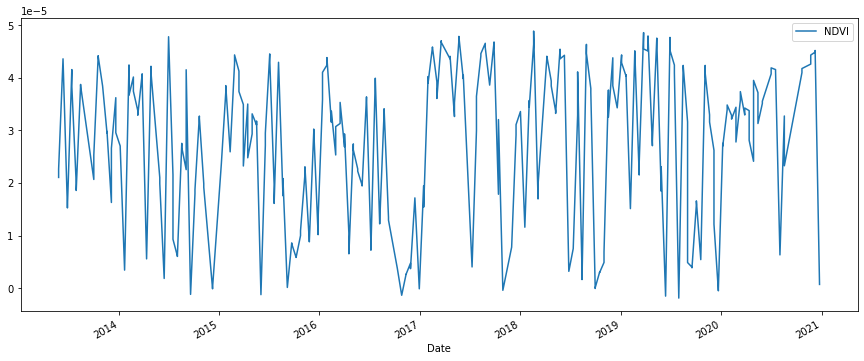

In [200]:
rcParams['figure.figsize'] = 15, 6
df.plot(y='NDVI',x='Date')
plt.show()

In [196]:
#animation.animate(imagesNDVI, {min: -1, max: 1,'palette': ['blue', 'white', 'green']})

NameError: ignored

In [227]:
input = withNDVI.sort('CLOUD_COVER_LAND').first()

region = ee.Geometry.Rectangle(117.666,0.598,117.766,0.698)

# Display the sample region.

map = folium.Map(location=[0.740,117.650],zoom_start=12)

map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')
map

In [230]:
training = input.sample(region = region,scale= 30,  numPixels= 5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(5).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

# Display the clusters with random colors.
map = folium.Map(location=[0.740,117.650],zoom_start=12,width='80%',height='80%')
map.addLayer(result.randomVisualizer().clip(roi), {}, 'clusters')
map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')
map.addLayer(first.clip(roi), {'min': 0, 'max': 30000, 'bands':['SR_B4','SR_B3','SR_B2'],'dimensions': 512})
folium.LayerControl().add_to(map)
map


In [247]:
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# Load training points. The numeric property 'class' stores known labels
0.7109218929065011, 117.64838889288357
0.744645267524037, 117.61973217267725
0.7593250740013487, 117.62621708330025
0.7152117540561972, 117.7326685925597

oilpalm = ee.Geometry.Rectangle(117.648, 0.711, 117.653, 0.716)
forest = ee.Geometry.Rectangle(117.619, 0.744, 117.624, 0.749)
other = ee.Geometry.Rectangle(117.626, 0.759, 117.631, 0.764)
water = ee.Geometry.Rectangle(117.732, 0.715, 117.737, 0.720)

# Make a FeatureCollection from the hand-made geometries.
polygons = ee.FeatureCollection([
  ee.Feature(oilpalm, {'class': 0}),
  ee.Feature(forest, {'class': 1}),
  ee.Feature(other, {'class': 2}),
  ee.Feature(water, {'class': 3}),
])


# This property stores the land cover labels as consecutive
# integers starting from zero.
training = input.sampleRegions(polygons, properties= ['class'], scale= 30)
  
# Create an SVM classifier with custom parameters.
# RBF = Radial Basis Function kernel
classifier = ee.Classifier.libsvm(kernelType='RBF',gamma= 0.5,cost= 10)

# Train the classifier.
trained = classifier.train(training, 'class', bands);

# Classify one image.

classified = input.classify(trained)

In [248]:
map = folium.Map(location=[0.740,117.650],zoom_start=12,width='80%',height='80%')

map.addLayer(polygons, {}, 'training polygons')
map.addLayer(classified, {'min': 0, 'max': 3, 'palette': ['red', 'green','grey','blue']}, 'deforestation')
map.addLayer(ee.Image().paint(roi, 0, 2), {}, 'region')
map.addLayer(first, {'min': 0, 'max': 30000, 'bands':['SR_B4','SR_B3','SR_B2'],'dimensions': 512})
folium.LayerControl().add_to(map)
map